# Deep Learning - Programing Assignment 1
# Multi-class Logistic Regression
By Shu-Nong Wu | RIN: 661371234 | RCS: wus7
## 1. Introduction
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
A prerequisite to understanding the neural network is to understand the fundamentals of machine learning. The goal of machine learning is given a input sample x, find the a mapping function f(x, theta) that maps x to the output y. Theta and hyperparameters will be discussed later in this report. 

$$ x --> f(x,\theta) --> y $$

In order to compute this mapping function there needs for be labeled training data which includes inputs and thier corresponding outputs. The process of finding the mapping function using labeled training data is known as supervised learning. The mapping function is comprised of parameters that takes in a input and generates a predicted a output. The function multiplies the inputs with weights and add a bias. The weights and biases are encoded into the theta matrix. This predicted output is compared the actual output given by the labels. By comparing these two values a loss can be computed based on the loss function L(D,theta).

$$ L(D, \theta) $$

Because this loss function represents how poorly the mapping function predicts outputs the goal is to minimize this loss function. For some machine learning problems, there is a closed form solution to minimize the loss by taking the derivative of the loss function and setting it to zero. 

$$ \frac{\partial(L(D,\theta))}{\partial(\theta)} = 0 $$

This will return the global minimum. However, not all machine learning problems provide a global minimum along with an closed form solution. In this case a method known as gradient decent can be use to iterativly estimate the be mapping function parameter to minimize the loss. Gradient decent works by taking the change in the loss function with respects to each value in theta also known as the gradient.

$$ \nabla_\theta L(D,\theta) $$

Because the goal is to minimize the loss, the gradient is multiplied by the something known as a learning rate and subtracted from the theta of the previous iteration.

$$ \theta^{t+1} = \theta^{t} - \eta\frac{\partial(L(D,\theta))}{\partial(\theta)}\Big|_{\theta=\theta^t} $$

The result is that these changes in theta gradually causes the loss function to "decent". The learning rate controls how much the gradient changes with each iteration. If the learning rate is too high then it will not converge because the weights and biases will constantly oscillate. If the learning rate is too low then gradient decent take a long time to minimize the loss function.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In this assignment two additional topics will be explored, stochastic gradient descent and regularization. Stochastic gradient descent involves taking the whole data set and dividing it up into batches of 2 to 100 data samples. At every iteration a random back is selected and used to compute the gradient and update theta. This method allows the loss function to converge faster and reach its local minimum. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
One fundamental problem in machine learning is called over fitting. If a model trains too many times on a certain dataset, it might become really good at mapping input to output for that dataset but might not perform well on an outside dataset. If basketball player plays only against aggressive player he or she will become an expert at playing against aggressive players. But when the player plays against someone with a passive play style, the he or she isn't guaranteed to perform well. This is a real life example of over fitting. To combat this, a regularization term is added to the loss function

$$ L(D,\theta)+\lambda R(\theta) $$

where lambda is a hyperparameter the determines the weighting of the regulization term. Taking the gradient of the new loss function gives the new learning formula.

$$ \theta^{t+1} = \theta^{t} - \eta[\nabla_\theta L(D,\theta) + \lambda\nabla_\theta R(\theta)] $$

#### Import Dependencies

In [3]:
import time
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pickle

#### Define Constants

In [4]:
NUM_TRAINING_SAMPLES = 25112
NUM_TESTING_SAMPLES = 4982
NUM_CLASSES = 5
width, height = 28, 28

#### Define Helper Classes

In [5]:
class Data:
    """
    The mnist dataset built into Tensorflow allows you to conveniently call the
    next_batch() function to get the next batch of data.
    This is just a reimplementation of that function.
    """
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data
        self.batch_num = 0
        
    def next_batch(self, batch_size):
        """
        Used for gradient descent when the input data set is too large.
        You can split it up into batches of BATCH_SIZE and iterate through the batches.
        """
        X_batch = self.X_data[self.batch_num*batch_size:(self.batch_num+1)*batch_size]
        Y_batch = self.Y_data[self.batch_num*batch_size:(self.batch_num+1)*batch_size]
        Y_batch = [one_hot(int(i)) for i in Y_batch]
        self.batch_num += 1
        return np.array(X_batch, dtype=np.float32).T.reshape(width*height, batch_size), \
               np.array(Y_batch, dtype=np.float32).T.reshape(NUM_CLASSES, batch_size)
    
    def random_batch(self, batch_size):
        """
        Used for stochastic gradient descent.
        Cuts the dataset into batches of BATCH_SIZE and randomly selects one of those batches
        """
        rand_batch_num = np.random.randint((len(self.X_data) / batch_size))
        X_batch = self.X_data[rand_batch_num*batch_size:(rand_batch_num+1)*batch_size]
        Y_batch = self.Y_data[rand_batch_num*batch_size:(rand_batch_num+1)*batch_size]
        Y_batch = [one_hot(int(i)) for i in Y_batch]
        return np.array(X_batch, dtype=np.float32).T.reshape(width*height, batch_size), \
               np.array(Y_batch, dtype=np.float32).T.reshape(NUM_CLASSES, batch_size)
    
    def reset(self):
        self.batch_num = 0

#### Define Helper Functions

In [6]:
def load_images():
    training_imgs = ['train_data/{:05d}.jpg'.format(i) for i in range(1, NUM_TRAINING_SAMPLES+1)]
    training_imgs = [cv2.imread(img, cv2.IMREAD_GRAYSCALE)/255 for img in training_imgs]
    width, height = training_imgs[0].shape
    training_imgs = [img.reshape(width*height, 1) for img in training_imgs]

    testing_imgs = ['test_data/{:04d}.jpg'.format(i) for i in range(1, NUM_TESTING_SAMPLES+1)]
    testing_imgs = [cv2.imread(img, cv2.IMREAD_GRAYSCALE)/255 for img in testing_imgs]
    testing_imgs = [img.reshape(width*height, 1) for img in testing_imgs]
    
    return training_imgs, testing_imgs

def load_labels():
    with open('labels/train_label.txt', 'r') as labels:
        training_labels = labels.read().split('\n')[0:-1]
        training_labels = [int(training_label) for training_label in training_labels]
        
    with open('labels/test_label.txt', 'r') as labels:
        testing_labels = labels.read().split('\n')[0:-1]
        testing_labels = [int(testing_label) for testing_label in testing_labels]
        
    return training_labels, testing_labels

def one_hot(number):
    """
    Converts a number into its one_hot representation
    Eg: 4 -> [0,0,0,1,0]
        2 -> [0,1,0,0,0]
    This is done because the output of our model is represented as nodes.
    The activation of a node corresponds to some output.
    """
    ones = np.ones((1,1),dtype=np.float32)
    zeros = np.zeros((NUM_CLASSES-1,1), dtype=np.float32)
    return np.roll(np.concatenate([ones, zeros]),number-1)

def softmax(logits, axis=0):
    """
    Typically used in the output layer of a network.
    Used for multinomial logistic regression.
    Abbreviated as sigma_m.
    """
    return tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)

def save_weights(theta):
    file = open('multiclass_parameters.txt', 'wb')
    pickle.dump(theta, file)
    file.close()

def plot_weight(w):
    img = w.reshape(28,28)
    plt.imshow(img)
    plt.colorbar()
    plt.show()
    

####  Load Data

In [7]:
training_imgs, testing_imgs = load_images()
training_labels, testing_labels = load_labels()
training_data = Data(training_imgs, training_labels)
testing_data = Data(testing_imgs, testing_labels)

## 2. Theory
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The important steps one must take to understand and perform learning with multiclass logistic regression is to set hyper parameters, initialize weights and biases, define the cost function, and compute the gradient and update the weights and biases.
### 2.1 Hyper Parameters
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Selecting hyper parameters affect the performance of a machine learning model. These hyper parameters include learning rate, lambda, epochs, batch size, and loss threshold. On a high level the learning rate affect the speed at which the loss functin converges and if it converges. Lambda affects how much the regulization term is weighted. Number of epochs affects the number of times the gradient is computed and subtracted to the weights and bias. Batch size is used for stochastic gradient descent and is the size of the dataset that is being used to calculate the gradient for each epoch. Finally the loss threshold stops the model from learning when the loss function goes below the threshold.

In [9]:
# Hyperparameters
LEARNING_RATE = .01
LAMBDA = .0001
NUM_EPOCHS = 10000
BATCH_SIZE = 100
LOSS_THRESH = .0000

### 2.2 Initalize Weights and Biases
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Before the model can be ran and optimized, the weights (w) and biases (w_0) must be initialized and put into the theta matrix. The theta matrix is defined as:

$$\theta = \left[\begin{array}{cccc} w \\ w_{0}\end{array} \right] $$

The initialization of weights and biases determines how soon the model will converge. Initializing the weights and biases such that the lost function starts off as close to the minimum as possible will mean that the number of epoch needed to reach that minimum is small. Alternatively the learning rate can be reduced in order to achieve a lower loss and higher testing accuracy in the same amount of training time.

In [10]:
X = tf.placeholder(dtype=tf.float32, shape=[width*height+1, None], name='images')
Y = tf.placeholder(dtype=tf.float32, shape=[NUM_CLASSES, None], name='labels')
w = tf.ones(shape=[width*height, NUM_CLASSES], dtype=tf.float32)*.1
w_0 = tf.zeros([1, NUM_CLASSES], dtype=tf.float32)
theta = tf.Variable(tf.concat([w, w_0], axis=0), dtype=tf.float32, name='theta')

### 2.3 Define Cost Function
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
When an input is being fed into the model it will generate a output. The cost function can intuitively be understood as given a predicted output how well does it match the real output. If the prediction is wrong when it is confident that its right the model will be punished with a high loss value. The loss function implemented for this project is know as negative log likelyhood. The loss or penalty for each sample is defined as

$$ L(D, \theta) = -\frac{1}{M} {\sum\limits_{m=1}^{M}\log p(Y[m]|X[m],\theta) = L(D, \theta) = - \frac{1}{M} \sum\limits_{m=1}^{M} \sum\limits_{k^{'}=1}^{K} Y[m][k^{'}] \log\sigma_m(\theta_k^t, X[m])} $$

where X is the input data and Y is the output data which both contains M samples which is the batch size in this case for stochastic gradient descent. The loss function can be used to check how close the model is to convergence.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Finally a regularization term is added in order to prevent overfitting. The regularization term being used in this assignment is L2 regularization and is defined as 

$$ R(\theta) = \theta^t\theta$$

and is added to the loss function

$$ L(D, \theta) = - \frac{1}{M} \sum\limits_{m=1}^{M} \sum\limits_{k^{'}=1}^{K}l[X[m],Y[m],\theta)+\lambda R(\theta)$$

In [11]:
logits = tf.matmul(tf.transpose(theta), X)
L2_reg = tf.reduce_sum(LAMBDA * tf.matmul(tf.transpose(theta), theta))
loss = -tf.reduce_sum(Y * tf.log(softmax(logits)))
loss = loss + L2_reg
loss = loss / BATCH_SIZE

### 2.4 Compute the Gradient and Update Theta
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In order to optimize the model the gradient of the loss function must be taken with respects to theta. What this gradient represents is how much should the weights and biases be change such that a small step can be taken to find the most accurate model. Simular to before the regularization term is added in order to prevent overfitting. The gradient along with the regularization is applied to the new weights for each class k and batch size M

$$ \nabla_{\theta,k} L(D,\theta) = -\frac{1}{M} \sum\limits_{m=1}^{M} X[m][y[m][k]-\sigma_m(\theta_k^t X[m])$$

regularization is defined as

$$ \nabla_{\theta,k} R(\theta_k) = 2 \theta$$

put it all together and the new weights can be calculated

$$ \theta_k^{t+1} = \theta_k^t - \eta[\nabla_{\theta,k} L(D,\theta)+\lambda\nabla_{\theta,k} R(\theta_k)] $$

The process of updating the weights with stochastic gradient descent is done over and over again with batch size M until convergence is reached.

In [12]:
L2_reg_gradient = 2 * LAMBDA * theta
delta_theta = tf.matmul(X, tf.transpose(Y - softmax(logits)))
delta_theta = delta_theta + LAMBDA * L2_reg_gradient
delta_theta = -LEARNING_RATE * delta_theta
delta_theta = delta_theta / BATCH_SIZE
update_theta = tf.assign_sub(theta, delta_theta)

## 3. Results
Using the following hyper parameters <br>
<br>
LEARNING_RATE = .01 <br>
LAMBDA = .01 <br>
NUM_EPOCHS = 10000 <br>
BATCH_SIZE = 100 <br>
LOSS_THRESH = .000001 <br>
<br>
an accuracy of 95 percent was obtained

In [14]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
        sess.run(init)
        
        #Train Model - Stochastic Gradient Decent
        loss_hist = []
        accuracy_hist_train = []
        accuracy_hist_test = []
        end_training = False
        for i in range(NUM_EPOCHS):    
            X_batch, Y_batch = training_data.random_batch(BATCH_SIZE)
            X_batch = np.concatenate([X_batch, np.ones((1,BATCH_SIZE), dtype=np.float32)])
            loss_value, _ = sess.run([loss, update_theta], feed_dict={X: X_batch, Y: Y_batch})
            loss_hist.append(loss_value) 
            
            # Check for conversion
            if len(loss_hist) > 0:
                loss_diff = (loss_value - loss_hist[-1]) / loss_hist[-1] * 100.
                if abs(loss_diff) < LOSS_THRESH:
                    end_training = True
                    break
            if end_training:
                break
            
            # Record Accuracies
            if not (i+1)%100:
                #Test Model - Train set
                Y_hat_train = sess.run(softmax(logits), feed_dict={X: X_batch, Y: Y_batch})
                correct_preds_train = tf.equal(tf.argmax(Y_hat_train, axis=0), tf.argmax(Y_batch, axis=0))
                train_accuracy = tf.reduce_mean(tf.cast(correct_preds_train, tf.float32))
                accuracy_train = sess.run(train_accuracy)
                accuracy_hist_train.append(accuracy_train)
                
                # Test Model - Test Set
                testing_data.reset()
                total_correct_preds = 0
                X_batch, Y_batch = testing_data.next_batch(NUM_TESTING_SAMPLES)
                X_batch = np.concatenate([X_batch, np.ones((1,NUM_TESTING_SAMPLES), dtype=np.float32)])
                Y_hat_test = sess.run(softmax(logits), feed_dict={X: X_batch, Y:Y_batch})
                correct_preds_test = tf.equal(tf.argmax(Y_hat_test, 0), tf.argmax(Y_batch, 0))
                accuracy_test = sess.run(tf.reduce_mean(tf.cast(correct_preds_test, dtype=tf.float32)))
                accuracy_hist_test.append(accuracy_test)
                
                print('Epoch: {:<10} | Loss: {:<20} | Test Accuracy {:<20}'.format(i+1, loss_value, accuracy_test))
        save_theta = sess.run(theta)
        save_weights(save_theta)

Epoch: 100        | Loss: 0.7218549251556396   | Test Accuracy 0.889000415802002   
Epoch: 200        | Loss: 0.6568701863288879   | Test Accuracy 0.9000401496887207  
Epoch: 300        | Loss: 0.41200920939445496  | Test Accuracy 0.9167001247406006  
Epoch: 400        | Loss: 0.4661306142807007   | Test Accuracy 0.9233239889144897  
Epoch: 500        | Loss: 0.44653213024139404  | Test Accuracy 0.9259333610534668  
Epoch: 600        | Loss: 0.37583762407302856  | Test Accuracy 0.9293456673622131  
Epoch: 700        | Loss: 0.35895249247550964  | Test Accuracy 0.9317542910575867  
Epoch: 800        | Loss: 0.37967026233673096  | Test Accuracy 0.9327579140663147  
Epoch: 900        | Loss: 0.2881816029548645   | Test Accuracy 0.9327579140663147  
Epoch: 1000       | Loss: 0.1972029060125351   | Test Accuracy 0.933159351348877   
Epoch: 1100       | Loss: 0.35727325081825256  | Test Accuracy 0.9329586625099182  
Epoch: 1200       | Loss: 0.30154046416282654  | Test Accuracy 0.93416297435

Epoch: 9900       | Loss: 0.3358621597290039   | Test Accuracy 0.9464070796966553  
Epoch: 10000      | Loss: 0.30505064129829407  | Test Accuracy 0.9464070796966553  


### 3.1 Plot Weights
Plotting the final weights for 1, 2, 3, 4, and 5 yields.

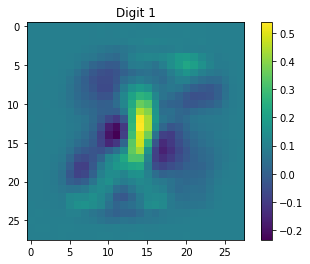

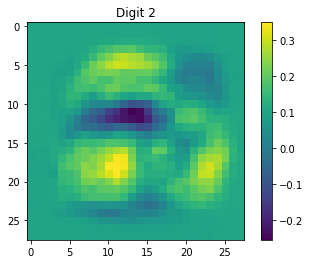

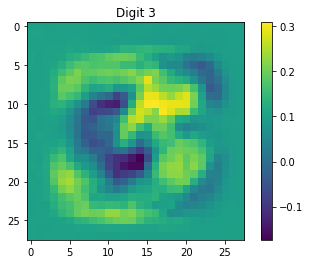

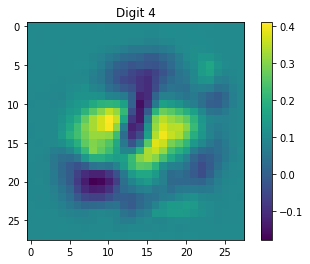

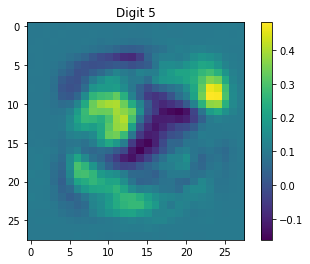

In [29]:
for i in range(5):
    plt.title('Digit {0}'.format(i+1))
    plot_weight(save_theta[:784,i])

### 3.2 Plot Accuracy Over Time

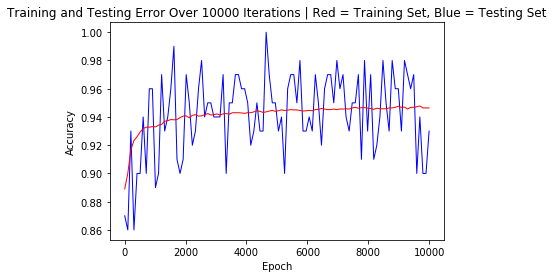

In [28]:
plt.plot(np.linspace(0, NUM_EPOCHS, int(NUM_EPOCHS/BATCH_SIZE)),
         accuracy_hist_train, 'b-', linewidth = 1.0)
plt.plot(np.linspace(0, NUM_EPOCHS, int(NUM_EPOCHS/BATCH_SIZE)),
         accuracy_hist_test,'r-', linewidth = 1.0)
plt.title('Training and Testing Error Over 10000 Iterations | Red = Training Set, Blue = Testing Set')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### 3.3 Plot Accuracy Per Digit 
Takeing my weights and testing on my friends plot accuracy per digit code the accuracies for each digits are: <br>
Accuracy for Digit 1: 0.9840225563909775 <br>
Accuracy for Digit 2: 0.9424242424242424 <br>
Accuracy for Digit 3: 0.9320388349514563 <br>
Accuracy for Digit 4: 0.9735503560528993 <br>
Accuracy for Digit 5: 0.9136612021857924 <br>